# Stationarity of the stochastic GW background


This notebook explores the stationarity of the stochastic GW background.

We are specifically interested in the quantity $a^{(n)}(t)$ which quantifies the influence of the stochastic GW backround on the $n$-th pulsar in a PTA. Please see the PTA P3 paper for a full definition of terms. We will assume that the reader of this notebook is somewhat familiar with the notation of PTA P3.



This notebook explores the shape of the curve $\langle a^{(n)}(t) a^{(n')}(t')\rangle (\tau)$ where $\tau = t - t'$ 


The $\langle \rangle$ brackets represent an ensemble average s.t. $\langle x\rangle = \frac{1}{N} \sum_{i=1}^N x_i$

The function $a^{(n)}(t)$ is the summation over $M$ individual GW sources applied to the $n$-th pulsar


### Summary of steps

To get the curve $\langle a^{(n)}(t) a^{(n')}(t')\rangle (\tau)$ we do the following:

* Specify two random pulsars, $n=1$, $n=2$.
* Specify an "observation plan", i.e. total timespan and cadence of the data (equivalently the discrete timesteps $t_k$)
* Specify the number of GW sources $M = 100$ 
* For a specific realisation of  $M = 100$ GW sources:
    * Compute $a^{(n=1)}(t)$
    * Compute $a^{(n=2)}(t)$
    * Calculate the product $\mathcal{A}(\tau) = a^{(n=1)}(t=0) \cdot a^{(n=2)}(t')$. 
* Repeat for J realisations of the M sources, and average



# 0. Imports and setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src") # Make modules in src easily available here by adding to path

In [3]:
#some useful quantities
year = 3.154e7 # in seconds
week = 604800  # in seconds

# 1. Defining the multiverse


To start, lets define the probability distributions over the 7 GW parameters.

To generate a BBH we sample each of these 7 parameters once.

To generate a universe, a population of BBH, we sample each of the 7 parameters M times.


In [5]:
from BH_population import BlackHolePopulation 

#Define the parameters for the power law over Ω
alpha = -3.0 #Exponent of the power law for the PDF of Ω
Ω_min = 1/(10*year) #lower bound on the Ω power law distribution. Set by Tobs
Ω_max = 1/(week)  #upper bound on the Ω power law distribution. Set by dt

BHMultiverseStatistics = BlackHolePopulation(alpha,Ω_min,Ω_max)

universe_i = Universe(BHMultiverseStatistics)
metaverse.sample(M=int(1e4))


AttributeError: 'BlackHolePopulation' object has no attribute 'sample'

(array([5.497e+03, 2.514e+03, 1.054e+03, 5.230e+02, 2.280e+02, 1.040e+02,
        4.600e+01, 1.700e+01, 1.300e+01, 4.000e+00]),
 array([-8.49885002, -8.32773462, -8.15661922, -7.98550381, -7.81438841,
        -7.643273  , -7.4721576 , -7.30104219, -7.12992679, -6.95881139,
        -6.78769598]),
 <BarContainer object of 10 artists>)

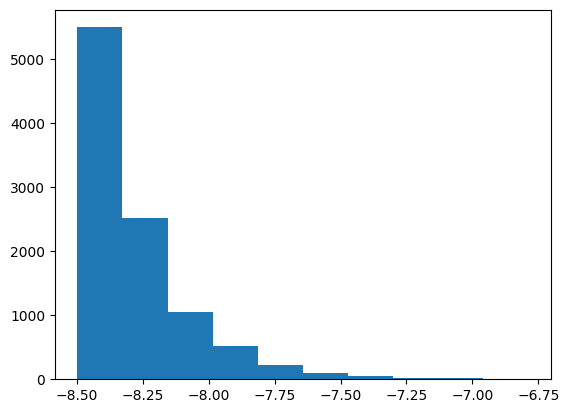

In [136]:
import matplotlib.pyplot as plt 
import numpy as np 
plt.hist(np.log10(universe_i.Ω))

# 2. Defining the PTA

In [137]:
from PTA import PTA 
Tobs = 10*year 
dt = 1*week
pulsars = PTA(Tobs=Tobs,dt=dt,seed=1)


# 3. Calculate $a(t)$

In [140]:
from calculate_gw import GW

SGWB = GW(universe_i,pulsars)
a = SGWB.compute_a()

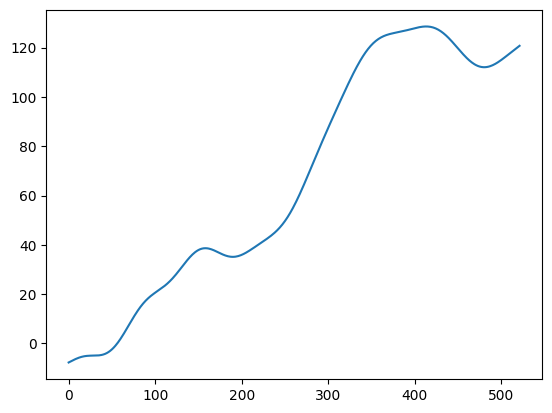

In [141]:
xx = np.arange(len(a))
yy = a[:,0]
plt.plot(xx,yy) 

# 4. Pipeline

Lets put all this together into a single pipeline 

In [163]:

#Define the parameters for the power law over Ω
alpha = -3.0 #Exponent of the power law for the PDF of Ω
Ω_min = 1/(10*year) #lower bound on the Ω power law distribution. Set by Tobs
Ω_max = 1/(week)  #upper bound on the Ω power law distribution. Set by dt
metaverse = BlackHolePopulation(alpha,Ω_min,Ω_max)


#Observation period
Tobs = 10*year 
dt = 1*week




def get_a_for_universe_i(pulsar_seed):

    metaverse.sample(M=int(1e4)) 
    pulsars = PTA(Tobs=Tobs,dt=dt,seed=pulsar_seed)


    #Given this universe and these pulsars, what is a(t)?
    SGWB = GW(metaverse,pulsars)
    a = SGWB.compute_a()

    a1 = a[:,0]
    a2 = a[:,1]


    #1D product
    ac = a1[0]
    product = ac*a2 


    #2D product
    outer_product = np.outer(a1,a2)

    return product,outer_product



In [164]:

pulsars = PTA(Tobs=Tobs,dt=dt,seed=1)
num_times = len(pulsars.t)

In [173]:

from tqdm import tqdm

num_realisations = 1000

array_1D = np.zeros((num_times,num_realisations)) #one timeseries for every seed. We will then average over this
array_2D = np.zeros((num_times,num_times)) #2D grid for a running sum

for i in tqdm(range(num_realisations)):
    product,outer_product = get_a_for_universe_i(pulsar_seed=1)

    array_1D[:,i] = product
    array_2D += outer_product

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [12:29<00:00,  1.33it/s]


In [177]:
#a couple of plotting functions


def plot_1d(t,array_1D):



    #Setup the figure
    h,w = 8,16
    rows = 3
    cols = 1
    fig, (ax1,ax2,ax3) = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharey=False,sharex=True)
    
    #t = t-t[0]
    year = 365*24*3600
    tplot = t / year


    for i in range(array_1D.shape[-1]):
        ax1.plot(tplot,array_1D[:,i])



    av = np.mean(array_1D,axis=1)
    sd = np.sqrt(np.var(array_1D,axis=1))


    ax2.plot(tplot,av)
    ax3.plot(tplot,sd)

    
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax3.set_xscale('log')



    ax2.set_xlim(tplot[1],tplot[-1])



    plt.subplots_adjust(hspace=0.05)



    # #Tidy it up
    fs=20
    ax3.set_xlabel(r'$\tau$ [years]', fontsize=fs)
   


    ax1.set_ylabel(r'$L^{(j)}(\tau)$', fontsize=fs) 
    ax2.set_ylabel(r'$L(\tau)$', fontsize=fs) 
    ax3.set_ylabel(r'$ \sigma \left[ L(\tau) \right]$', fontsize=fs) 

    for ax in fig.axes:
        ax.xaxis.set_tick_params(labelsize=fs-4)
        ax.yaxis.set_tick_params(labelsize=fs-4)
        ax.set_xscale('log')


    plt.show()



from labellines import labelLines 
def plot_2d(t,array_2D,plot_points=False,num_contours=100):





    #Setup the figure
    h,w = 8,8
    rows = 1
    cols = 1
    fig, ax1 = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w))



    xx_years = t / (365*24*3600) #cadence = 1 day
    yy_years = t / (365*24*3600)


    ax1.contour(xx_years, yy_years, array_2D, cmap='viridis',levels=num_contours)




    def fixed_contour(x,c):
        return x + c 

    cs = [0,1,2,3]
    ls = ['solid','dotted','dashed','dashdot']
    for i in range(len(cs)):

        y1 = fixed_contour(xx_years,cs[i])
        ax1.plot(xx_years,y1,c='0.5', linestyle=ls[i],label=str(cs[i])+'yr')



        y1 = fixed_contour(xx_years,-cs[i])
        ax1.plot(xx_years,y1,c='0.5', linestyle=ls[i],label=str(cs[i])+'yr')

    fs=20
    ax1.xaxis.set_tick_params(labelsize=fs-4)
    ax1.yaxis.set_tick_params(labelsize=fs-4)

    ax1.set_ylim(0,10)
    ax1.set_xlim(0,10)

    ax1.set_xlabel(r'$t$ [years]', fontsize=fs)
    ax1.set_ylabel(r"$t'$ [years]", fontsize=fs) 


    if plot_points:
        X,Y = np.meshgrid(xx_years,yy_years)
        ax1.scatter(X.flatten(),Y.flatten(),s=2,marker='x')

    
    lines=plt.gca().get_lines()
    xv = np.ones(len(lines))*5
    labelLines(lines,align=True,xvals=xv,fontsize=fs-6)



plt.show()









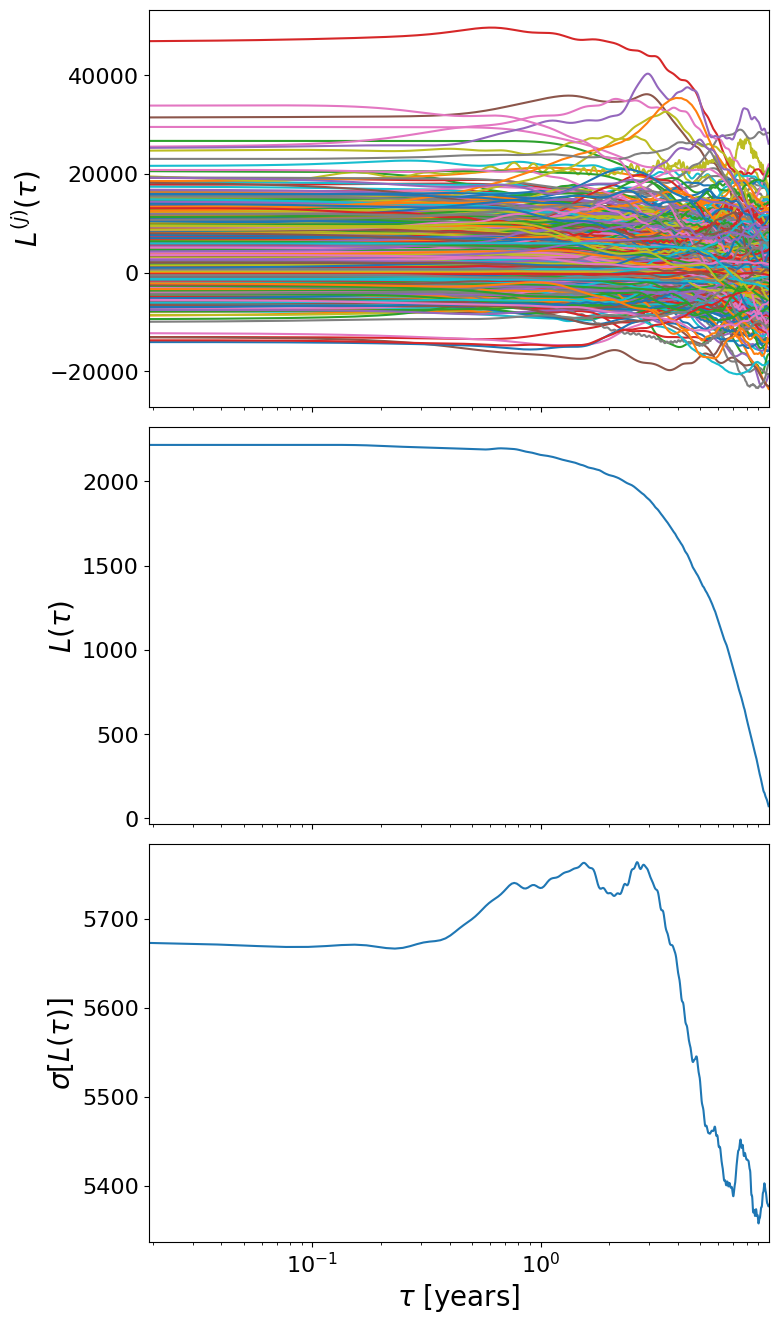

In [178]:
plot_1d(pulsars.t,array_1D)

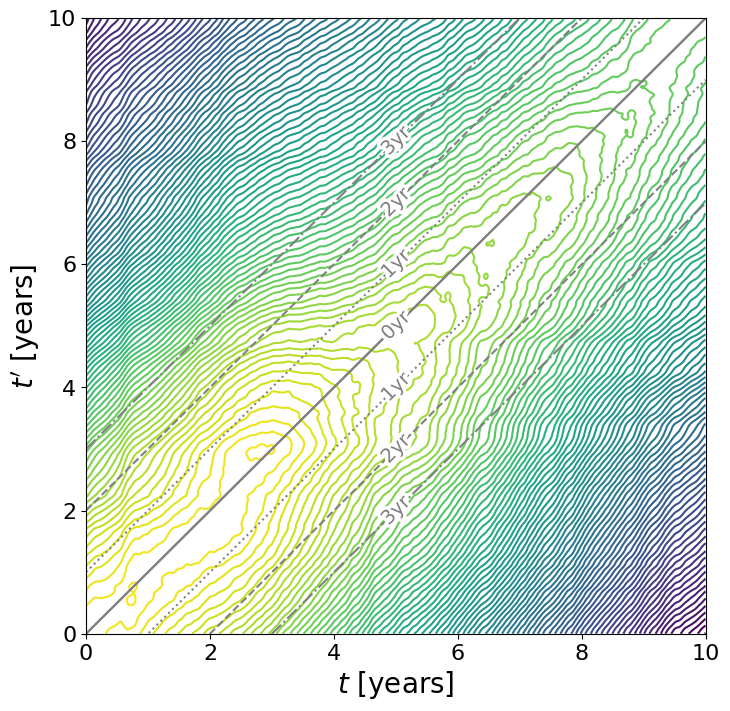

In [181]:
plot_2d(pulsars.t,array_2D)

In [ ]:

#Define the parameters for the power law over Ω
alpha = -3.0 #Exponent of the power law for the PDF of Ω
Ω_min = 1/(10*year) #lower bound on the Ω power law distribution. Set by Tobs
Ω_max = 1/(week)  #upper bound on the Ω power law distribution. Set by dt
metaverse = BlackHolePopulation(alpha,Ω_min,Ω_max)



In [182]:
from BH_population import Universe 

In [183]:
Universe(100)

AttributeError: 'Universe' object has no attribute 'alpha'